# RETO MINSAIT
Participantes:
* Juan Luis Ruiz-Tagle
* Jorge Martín
* mateusz Klimas
Centro: UPM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import *

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importamos los datos

In [2]:
estimate = pd.read_csv("Estimar_UH2020.txt", sep = "|")
data = pd.read_csv("Modelar_UH2020.txt", sep = "|")
total = pd.concat([data,estimate])

## Comprobamos cual es la distribución por clases

<BarContainer object of 7 artists>

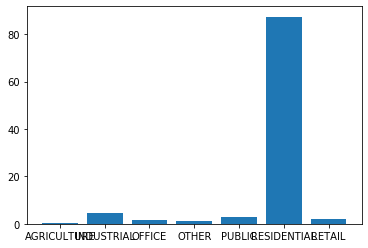

In [3]:
# Distribucion de las clases en los datos
d = total[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, class_percentage["X"])

# Clases balanceadas
Sabemos que el archivo estimate contiene datos de clases mucho más balanceadas. Decidimos descartar muchos datos de tipo residential y nos quedamos con un dataset mucho más equilibrado


<BarContainer object of 7 artists>

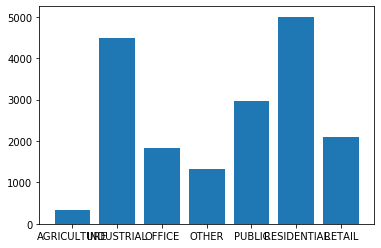

In [4]:
import random

# Datos de la clase "residential"
residential_data = data[data.CLASE=="RESIDENTIAL"]

# Escogemos 5000 índices de las instancias de manera aleatoria
residential_sample_indexes = random.sample(list(residential_data.index), 5000) 
residential_sample = residential_data.loc[residential_sample_indexes]

# Almacenamos los datos no escogidos por la muestra aleatoria
residential_not_in_sample = residential_data.drop(residential_sample_indexes)

# De los datos originales, eliminamos todos los residential
no_residential_data = data[data.CLASE!="RESIDENTIAL"]

# Unimos los datos no residential con la muestra aleatoria
balanced_data = no_residential_data.append(residential_sample)

# Distribucion de las clases en los datos
d = balanced_data[["X","CLASE"]].groupby("CLASE").count()
class_percentage = d/d["X"].sum()*100
plt.bar(d.index, d.X)

# Correlation matrix
Para ver las relaciones existentes entre las variables, primero las estandarizamos y luego mostramos la matriz de correlación.
Esta estandarización no se aplica a cada variable por separado, sino a grupos de variables, en concreto:
* El grupo de deciles de los 4 canales,
* Las coordenadas X e Y
* La variables de geometría del terreno
* El resto de variables se estandarizan individualmente

Esto se hace para no perder información entre las proporciones de unas variables y otras.
También se crea una escala ordinal para la variable catastral_quality.

Para ver la correlación entre las clases primero se aplica OneHotEncoding a las clases, creando 7 nuevas columnas. Estas columnas se convierten en la variable a predecir
Todo esto se hace en la función ``process_data()``


In [5]:
balanced_data_std = process_data(balanced_data)

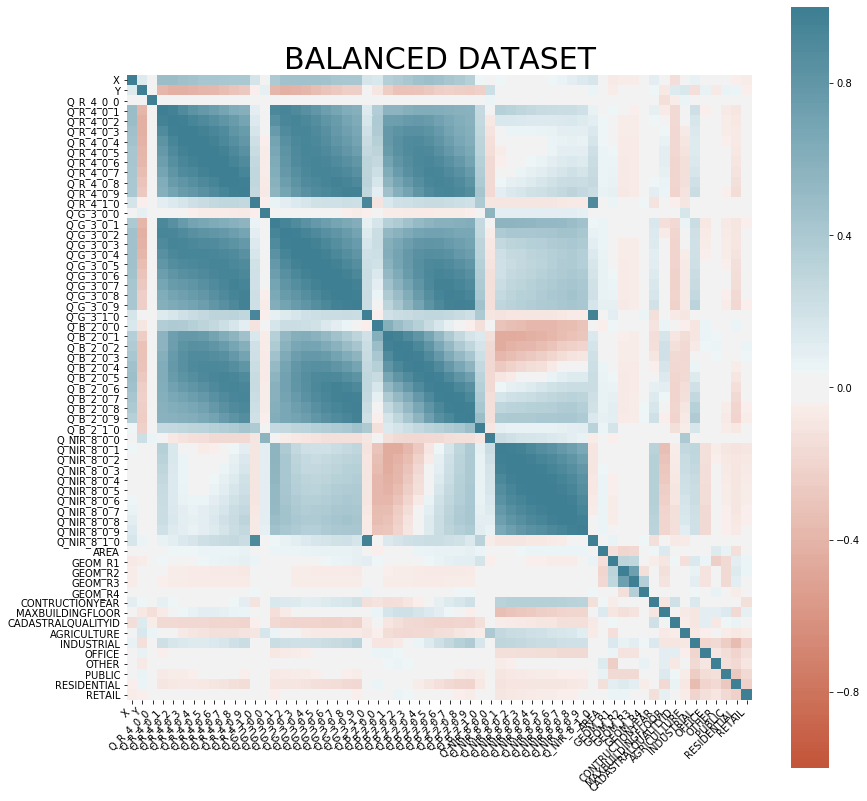

In [6]:
plot_corr(balanced_data_std, "BALANCED DATASET")

En el mapa de correlación anterior, se puede apreciar como las colas de los canales de color (deciles 0 y 10) no aportan ningún tipo de información. Lo comprobaremos más adelante.
También se aprecia cierta correlación inversa entre los primeros deciles del canal NIR y el azul

# Canales RGB y NIR
A continuación se muestran las medias de cada decil para cada canal en cada tipo de terreno.
Vemos cómo la distribución de colores es muy distinta en muchos de estos casos. En cambio, vemos como los deciles 0 y 10 prácticamente siempre tienden al 0

C:\Users\HPfamiliaRuiz-Tagle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


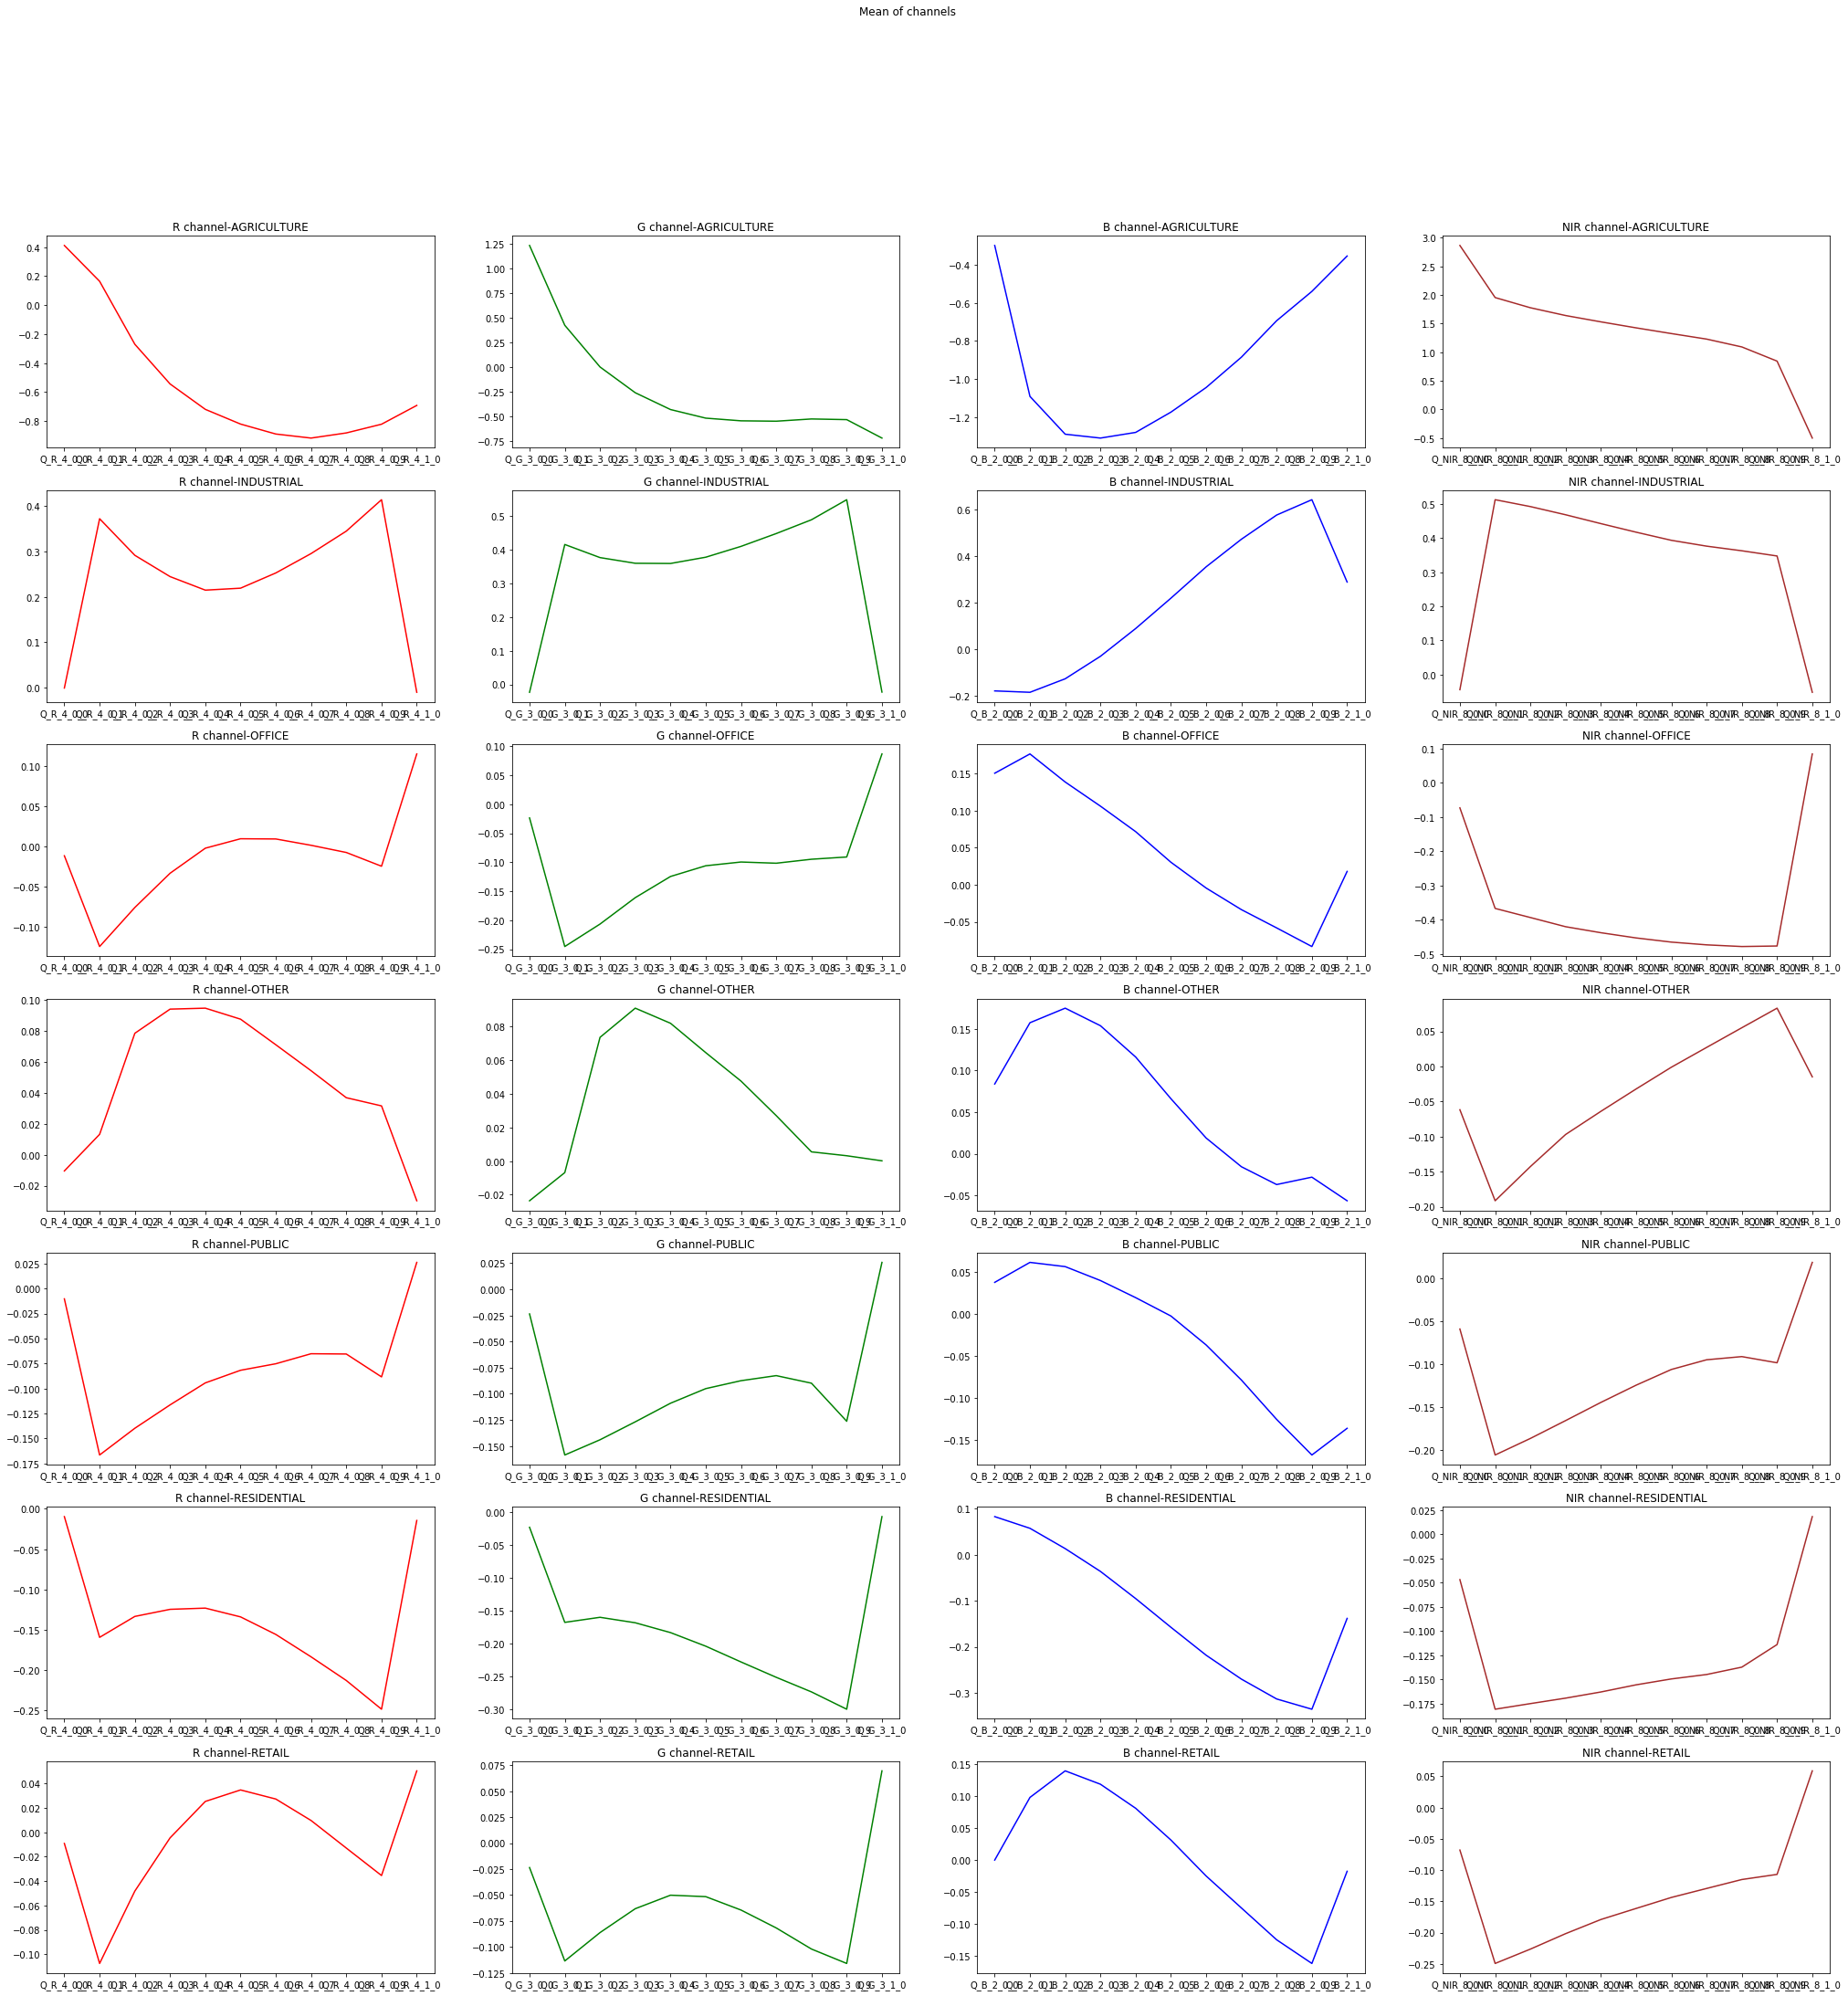

In [7]:
rgbnir_cols = balanced_data_std.columns.str.contains("Q_")
group = balanced_data_std.iloc[:,rgbnir_cols]
group["CLASE"] = balanced_data_std["CLASE"]
class_mean = group.groupby("CLASE").mean()
plot_all_channels(class_mean)

# Neural model
Vemos como las distribuciones tienen formas muy particulares. Las colas de cada distribución se tienen que descartar. 
Está claro que el orden de los deciles tiene que preservarse de alguna manera, y no podemos pasar las variables de forma individual. En un primer intento intentamos codificar estas distribuciones con polinomios de segundo grado, pero no funcionó muy bien.

En el siguiente intento, decidimos crear una red compuesta que tratara por un lado los datos de los canales de color con una CNN de 1 dimension, y por otro una red Densa que aprendiera del resto de datos. Estas dos redes se combinan al final.
En el entrenamiento dejamos de incluir las variables ``MAXBUILDINGFLOOR`` y ``CADASTRALQUALITYID`` pues bloqueaban el entrenamiento

In [8]:
balanced_data_std.columns

Index(['ID', 'X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3',
       'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8',
       'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2',
       'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7',
       'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
       'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6',
       'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0',
       'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4',
       'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8',
       'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'CLASE', 'AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL'],
      dtype='object')

## Preparamos los datos para entrenar el modelo

In [ ]:
from sklearn.model_selection import train_test_split
labels = balanced_data_std[['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC',
       'RESIDENTIAL', 'RETAIL']]

x_train, x_test, t_train, t_test = train_test_split(balanced_data_std, labels, test_size=0.1, random_state=1)
data_dense_train = x_train[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]
data_dense_test = x_test[['X', 'Y','AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR']]

df_r, df_g, df_b, df_nir = extract_channels(x_train, True, False, False, True)
data_rgbnir_train = merge_for_Cnn1(df_r, df_g, df_b, df_nir)

df_r, df_g, df_b, df_nir = extract_channels(x_test, True, False, False, True)
data_rgbnir_test = merge_for_Cnn1(df_r, df_g, df_b, df_nir)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Concatenate, Input, concatenate, BatchNormalization
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.initializers import glorot_normal


def merged_net():
    
    dropout_rate = 0.2
    
    #DENSE net
    dense_input = Input(shape=(data_dense.shape[1],), name='main_input')
    dense = Dense(250, activation='relu')(dense_input)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(200, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense = BatchNormalization()(dense)
    dense= Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense_out = BatchNormalization()(dense)
    dense= Dense(100, activation='relu')(dense)
    dense = Dropout(dropout_rate)(dense)
    dense_out = BatchNormalization()(dense)
    
    #CNN1D
    seq_length = 9
    kernel = 2
    
    cnn_input = Input(shape=(seq_length,4), name='cnn_input')
    cnn = Conv1D(32, kernel_size= kernel, activation='relu')(cnn_input)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(64, kernel_size= kernel, activation='relu')(cnn)
    cnn = Conv1D(128, kernel_size= kernel, activation='relu')(cnn)
    cnn = Flatten()(cnn)
    cnn_out = Dropout(dropout_rate)(cnn)
    

    #MERGED net
    concat = concatenate([cnn_out, dense_out])
    concat = Dense(50, activation='relu')(concat)
    model_output = Dense(7, activation='sigmoid')(concat)
    
    model = Model(inputs=[cnn_input, dense_input], outputs=[model_output])

    model.compile(loss='categorical_crossentropy',
                  optimizer= "adam" ,
                  metrics=['accuracy'])
    return model

## Creamos el modelo y lo entrenamos 200 epochs

In [ ]:
model = merged_net()
history = model.fit([data_rgbnir_train, data_dense_train], t_train.values,batch_size = 32, epochs = 200)


In [9]:
def evaluate_and_plot(model, history):
    score = model.evaluate([data_rgbnir_test, data_dense_test],t_test)
    print("loss=" + str(score[0]) + " accuracy=" + str(score[1]))
    plt.plot(history.history['acc'])

1806/1806 [==============================] - 1s 445us/step
loss=1.2387430972831195 accuracy=0.5825027686152875


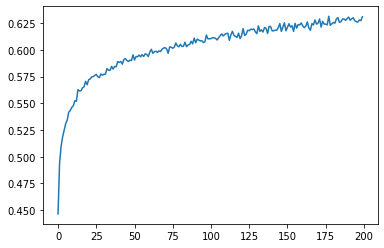

In [109]:
evaluate_and_plot(model, history)

### Predecimos con el modelo y exportamos los datos

In [ ]:
estimate_std = process_data(estimate)
estimate_features, labels = create_features(estimate_std)

In [ ]:
predictions = model.predict([data_rgbnir_estimate,data_dense_estimate])
dictionary = {i: terreno for i , terreno in zip(range(7),t_train.columns.values)}
results = []
for p in predictions:
    pos = np.argmax(p)
    results.append(dictionary.get(pos))
final_result = pd.concat([estimate["ID"],pd.DataFrame(results)], axis = 1)
final_result.columns = ["ID","CLASE"]

In [ ]:
def generate_output(df, name = "UPM_bestermans.txt"):
    df.columns =   ["ID","CLASE"]
    df.to_csv(name, sep = "|", index = False)